In [1]:
# Change working directory
%cd ..

d:\HUST\OT factorization\ot-kpgf


c:\Users\nguye\Apps\anaconda3\envs\ot-kpgf\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments import OutlierRate, ClusterMismatch, Dimensionality
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Dimension: 5, Accuracy: {'KeypointFOT': 0.5975, 'FOT': 0.155, 'LOT': 0.2175, 'OT': 0.2225}, Runtime: {'KeypointFOT': 24.118560552597046, 'FOT': 12.900525569915771, 'LOT': 0.19252347946166992, 'OT': 0.06473469734191895}
Dimension: 10, Accuracy: {'KeypointFOT': 0.4675, 'FOT': 0.1525, 'LOT': 0.215, 'OT': 0.22}, Runtime: {'KeypointFOT': 24.67089080810547, 'FOT': 14.392377614974976, 'LOT': 0.20289206504821777, 'OT': 0.04600381851196289}
Dimension: 15, Accuracy: {'KeypointFOT': 0.505, 'FOT': 0.16, 'LOT': 0.215, 'OT': 0.21}, Runtime: {'KeypointFOT': 24.279475927352905, 'FOT': 10.549901247024536, 'LOT': 0.23495149612426758, 'OT': 0.08680868148803711}
Dimension: 20, Accuracy: {'KeypointFOT': 0.605, 'FOT': 0.1625, 'LOT': 0.21, 'OT': 0.215}, Runtime: {'KeypointFOT': 24.266874313354492, 'FOT': 17.802499294281006, 'LOT': 0.2479109764099121, 'OT': 0.0671694278717041}
Dimension: 25, Accuracy: {'KeypointFOT': 0.57, 'FOT': 0.1675, 'LOT': 0.2175, 'OT': 0.2125}, Runtime: {'KeypointFOT': 24.37138938903808

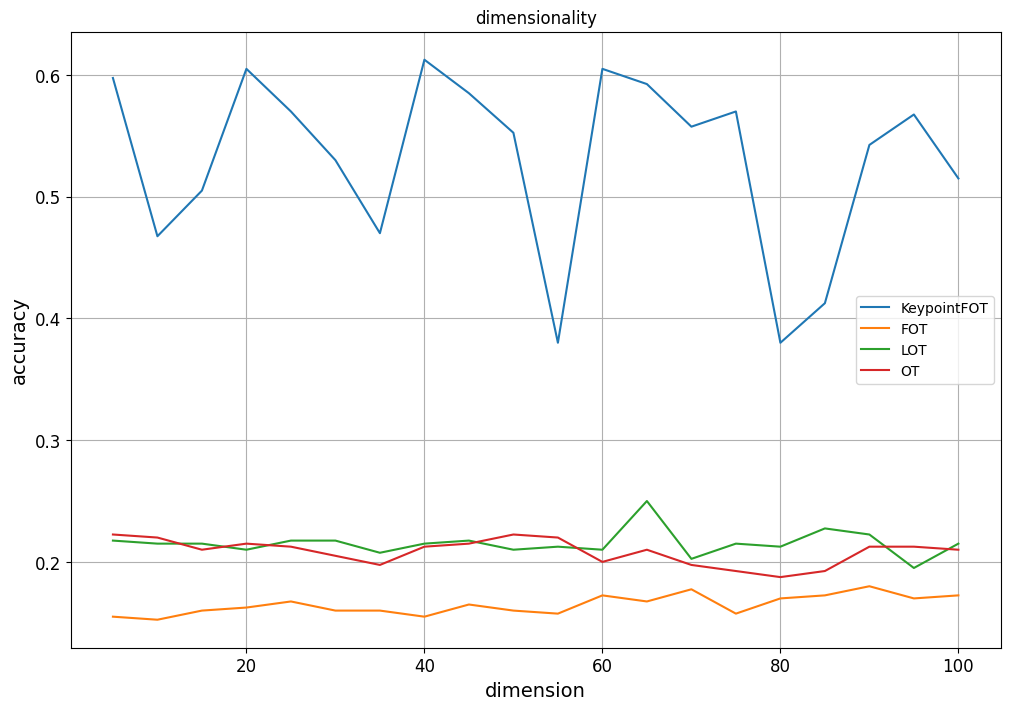

In [3]:
#@title Dimensionality
n_anchors = 4
n_keypoints = 4
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, 5-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = Dimensionality(model=models, log_dir="logs")
results = experiment(
    noise_level=1, max_projected_dim=100, freq_projected_dim=5, hyperplane_dim=5,
    n_components=k, cluster_samples=100, n_keypoints=n_keypoints, 
    src_properties={"means": mean_s, "cov_scale": 0.1},
    trg_properties={"means": mean_t, "cov_scale": 0.1}
)

Noise ratio: 0.0, Accuracy: {'KeypointFOT': 0.9925, 'FOT': 0.25, 'LOT': 0.2725, 'OT': 0.2575}, Runtime: {'KeypointFOT': 0.4494149684906006, 'FOT': 0.6877164840698242, 'LOT': 1.2235419750213623, 'OT': 0.0653982162475586}
Noise ratio: 0.1, Accuracy: {'KeypointFOT': 0.9775, 'FOT': 0.2475, 'LOT': 0.2725, 'OT': 0.25}, Runtime: {'KeypointFOT': 0.7278642654418945, 'FOT': 5.688206434249878, 'LOT': 1.2093491554260254, 'OT': 0.06015419960021973}
Noise ratio: 0.2, Accuracy: {'KeypointFOT': 0.9825, 'FOT': 0.2475, 'LOT': 0.26, 'OT': 0.2525}, Runtime: {'KeypointFOT': 1.0204362869262695, 'FOT': 3.5237345695495605, 'LOT': 1.307891845703125, 'OT': 0.061850547790527344}
Noise ratio: 0.30000000000000004, Accuracy: {'KeypointFOT': 0.99, 'FOT': 0.0125, 'LOT': 0.22, 'OT': 0.2475}, Runtime: {'KeypointFOT': 0.6731557846069336, 'FOT': 4.581192255020142, 'LOT': 1.2061302661895752, 'OT': 0.06818222999572754}
Noise ratio: 0.4, Accuracy: {'KeypointFOT': 0.9725, 'FOT': 0.4825, 'LOT': 0.24, 'OT': 0.2475}, Runtime: {

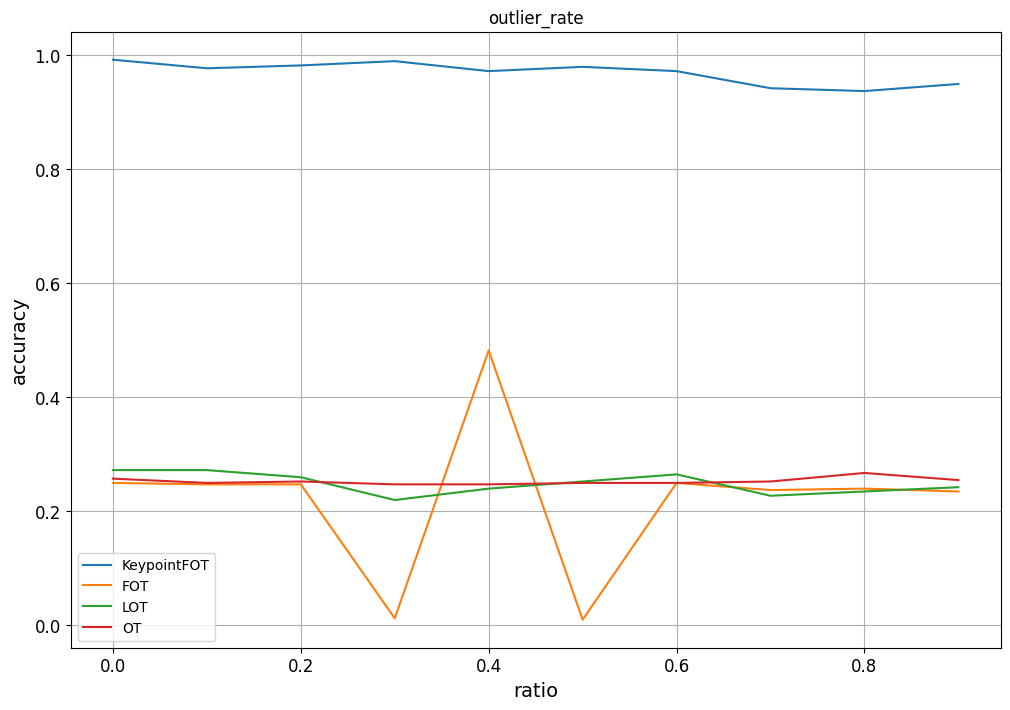

In [4]:
#@title Outlier rate
n_anchors = 4
n_keypoints = 4
d = 30
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.0005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = OutlierRate(model=models, log_dir="logs")
results = experiment(max_noise_ratio=1, freq_noise_ratio=0.1, hyperplane_dim=d, 
                     cluster_samples=100, n_keypoints=n_keypoints, n_components=k,
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                    )

Number of source components: 2, Accuracy: {'KeypointFOT': 0.57, 'FOT': 0.08, 'LOT': 0.0, 'OT': 0.12}, Runtime: {'KeypointFOT': 2.1875696182250977, 'FOT': 4.1896162033081055, 'LOT': 0.44704675674438477, 'OT': 0.073577880859375}
Number of source components: 2, Accuracy: {'KeypointFOT': 0.57, 'FOT': 0.08, 'LOT': 0.0, 'OT': 0.12}, Runtime: {'KeypointFOT': 2.1875696182250977, 'FOT': 4.1896162033081055, 'LOT': 0.44704675674438477, 'OT': 0.073577880859375}
Number of source components: 3, Accuracy: {'KeypointFOT': 0.5433333333333333, 'FOT': 0.08333333333333333, 'LOT': 0.0, 'OT': 0.15666666666666668}, Runtime: {'KeypointFOT': 2.578674554824829, 'FOT': 4.6909401416778564, 'LOT': 0.5651447772979736, 'OT': 0.11274433135986328}
Number of source components: 3, Accuracy: {'KeypointFOT': 0.5433333333333333, 'FOT': 0.08333333333333333, 'LOT': 0.0, 'OT': 0.15666666666666668}, Runtime: {'KeypointFOT': 2.578674554824829, 'FOT': 4.6909401416778564, 'LOT': 0.5651447772979736, 'OT': 0.11274433135986328}
Numb

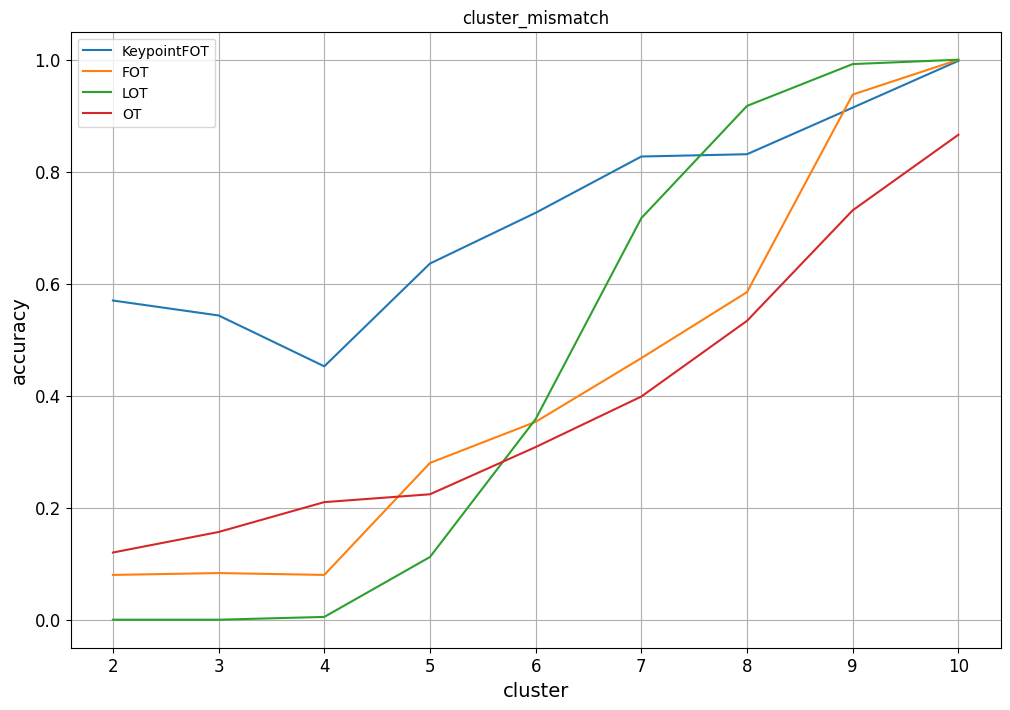

{'KeypointFOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.57,
   0.5433333333333333,
   0.4525,
   0.636,
   0.7266666666666667,
   0.8271428571428572,
   0.83125,
   0.9144444444444444,
   0.998],
  'runtime': [2.1875696182250977,
   2.578674554824829,
   15.410084009170532,
   2.7259936332702637,
   5.08164644241333,
   3.4578840732574463,
   5.419995069503784,
   5.031069993972778,
   4.846165418624878]},
 'FOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.08,
   0.08333333333333333,
   0.08,
   0.28,
   0.35333333333333333,
   0.46714285714285714,
   0.585,
   0.9377777777777778,
   1.0],
  'runtime': [4.1896162033081055,
   4.6909401416778564,
   3.6408820152282715,
   6.581112623214722,
   5.194434404373169,
   5.028937578201294,
   4.782692193984985,
   2.872912883758545,
   3.14251708984375]},
 'LOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.0,
   0.0,
   0.005,
   0.112,
   0.35833333333333334,
   0.7171428571428572,
   0.9175,

In [6]:
#@title ClusterMismatch
n_anchors = 4
n_keypoints = 10
d = 30
k = 10
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.0005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = ClusterMismatch(model=models, log_dir="logs")
results = experiment(min_source_components=2, freq_components=1, target_components=k, 
                    hyperplane_dim=d, cluster_samples=100, n_keypoints=n_keypoints,
                    src_properties={"means": mean_s, "cov_scale": 0.1},
                    trg_properties={"means": mean_t, "cov_scale": 0.1},
                    )